## Pauli Transfer Matrix extraction
$\def\bra#1{\mathinner{\left\langle{#1}\right|}}\def\ket#1{\mathinner{\left|{#1}\right\rangle}}$

In [30]:
import numpy as np; pi = np.pi
import scipy.io as spio
import sys
import bisect
from qutip import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# Figures should have a width of a 8.6 cm or 3 3/8 in, the width of a single manuscript column.
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = 3+3/8 # width in inches
fig_height = fig_width*golden_mean # height in inches (0.75 is the standard height to width ratio in Python)
fig_size = [fig_width, fig_height]
mpl.rcParams.update({
    'axes.labelsize' : 12,
    'font.size' : 12,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'ytick.minor.pad' : -0.5,
    'ytick.minor.pad' : -0.5,
    'ytick.major.size' : 1,
    'ytick.minor.size' : 1,
    'ytick.major.width' : .5,
    'ytick.minor.width' : .5,
    'xtick.major.size' : 1,
    'xtick.minor.size' : 1,
    'xtick.major.width' : .5,
    'xtick.minor.width' : .5,
    'xtick.major.pad' : 1.5,
    'xtick.minor.pad' : 1.5,
    'text.usetex' : True,
    'figure.dpi' : 100,
})

## Parameters

In [54]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # kerr amplitude
G = 4*K # two photon pump amplitude
alpha = np.sqrt(G/K) # coherent state amplitude

# cat states
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity in computational basis
I = up*up.dag() + down*down.dag()

# sigma-z in computational basis
sigma_z = up*up.dag() - down*down.dag()

# sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()

# sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

# Array with Pauli matrices
P = [I, sigma_x, sigma_y, sigma_z]

## $R_z(\phi)$-gate
This has the PTM
$$
R =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & \cos\phi & -\sin\phi & 0 \\
0 & \sin\phi & \cos\phi & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
$$

In [55]:
# gate time
T_g = 2

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*t/T_g)

# Hamiltonian
H0 = - K * pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))
H1 = a.dag() + a
H_tot = [H0,[H1,E]]

## The fast way

In [175]:
phi = pi/4 # angle of rotation
gamma = 1/1500 # single-photon loss rate
c_ops = np.sqrt(gamma)*a # collapse operator

# For precise calculation
opt = Options(nsteps=15e3, atol=1e-8, rtol=1e-6)

d = 2
# pauli transfer matrix
R = np.zeros((d**2,d**2))
for j in range(d**2):
    rho = mesolve(H_tot, P[j], [0,T_g] , c_ops, args = {'phi': phi}, options = opt)
    Lambda = rho.states[-1]
    for i in range(d**2):
        R[i,j] = 1/d * np.real((P[i]*Lambda).tr())
R = Qobj(R,dims=[[[2],[2]] for i in range(d)]) # Make quantum object

## test

In [176]:
def op2vec(rho):
    d = 2
    vec_rho = np.zeros((d**2,1))
    P = [qeye(d)/np.sqrt(d),sigmax()/np.sqrt(d),sigmay()/np.sqrt(d),sigmaz()/np.sqrt(d)]
    for k in range(d**2):
        vec_rho[k] = (P[k]*rho).tr()
    vec_rho = Qobj(vec_rho, dims=[[[2],[2]],[1]])
    return vec_rho

def vec2op(vec_rho):
    d = 2
    P = [qeye(d)/np.sqrt(d),sigmax()/np.sqrt(d),sigmay()/np.sqrt(d),sigmaz()/np.sqrt(d)]
    rho = sum([P[k]*(vec_rho[k]).flatten()[0] for k in range(d**2)])
    return rho

In [177]:
ket0 = basis(2,0)
ket1 = basis(2,1)
psi = (ket0+ket1).unit()
rho = ket2dm(psi) # initial rho
vec_rho = op2vec(rho)
vec_rho_final = R*vec_rho
rho_final = vec2op(vec_rho_final)

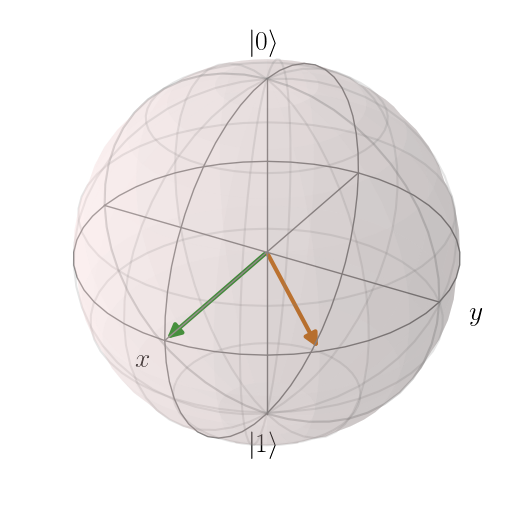

In [179]:
B = Bloch()
B.add_states(rho)
B.add_states(rho_final)
#B.add_states(t)
B.show()

## The slow way

### quantum map

A quantum map $\Lambda$ is the following.
$$
    \Lambda
    = \begin{pmatrix}
        \Lambda'(\ket{0}\bra{0}) & \cdots & \Lambda'(\ket{0}\bra{20}) \\
        \vdots & \ddots & \vdots \\
        \Lambda'(\ket{20}\bra{0}) & \cdots & \Lambda'(\ket{20}\bra{20})
    \end{pmatrix}
$$
$\Lambda'(\ket{i}\bra{j})$ is $20\times 20$ matrix, so $\Lambda$ is $20^2\times 20^2$ matrix.

In [102]:
phi = pi/4 # angle of rotation
gamma = 1/1500 # single-photon loss rate
c_ops = np.sqrt(gamma)*a # collapse operator

# For precise calculation
opt = Options(nsteps=15e3, atol=1e-8, rtol=1e-6)

# Quantum map
qmap = propagator(H_tot, T_g, c_op_list = [c_ops], args = {'phi': phi}, options = opt)

### save quantum map

In [59]:
qsave(qmap,"results/rz"+str(phi))

### Kraus map
$$
\Lambda(\rho) = \sum_{k=1}^N A_k\rho A_k^\dagger
$$
where $A_k$ are Kraus-operators

In [103]:
kraus_form = to_kraus(qmap)

### Pauli transfer matrix
$$
(R_\Lambda)_{ij} = \frac{1}{d}\mathrm{Tr}[P_i\Lambda(P_j)] = \frac{1}{d}\sum_{k=1}^N\mathrm{Tr}[P_iA_kP_jA_k^\dagger]
$$

In [104]:
d = 2
# pauli transfer matrix
R = np.zeros((d**2,d**2))
for i in range(d**2):
    for j in range(d**2):
        R[i,j] = 1/d * np.real(sum([(P[i]*A_k*P[j]*A_k.dag()).tr() for A_k in kraus_form]))
R = Qobj(R,dims=[[[2],[2]] for i in range(d)]) # Make quantum object

## $R_x(\theta)$-gate

In [45]:
T_g = 10/K # gate time
theta = pi/2 #2*np.pi - 2*2.6893
theta_list = np.load("results/theta-list.npy")
delta_list = np.load("results/delta-list.npy")

def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect.bisect_right(a, x)
    if i:
        return i
    raise ValueError

# find which delta that corresponds to a specific theta
z = find_le(theta_list,theta)
(x1,x2) = (delta_list[z-1], delta_list[z])
(y1,y2) = (theta_list[z-1], theta_list[z])
y = theta
x = (y-y1)*(x2-x1)/(y2-y1)+x1
delta = x

# detuning
def Delta(t,args):
    delta = args['delta']
    return delta * pow(np.sin(np.pi*t/T_g),2)

# Hamiltonian
H0 = - K * pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))
H1 = - a.dag()*a
H_tot = [H0,[H1,Delta]]

In [46]:
gamma = 1/1500 # single-photon loss rate
c_ops = np.sqrt(gamma)*a # collapse operator

# For precise calculation
opt = Options(nsteps=25e3, atol=1e-8, rtol=1e-6)

d = 2
# pauli transfer matrix
R = np.zeros((d**2,d**2))
for j in range(d**2):
    rho = mesolve(H_tot, P[j], [0,T_g] , c_ops, args = {'delta': delta}, options = opt)
    Lambda = rho.states[-1]
    for i in range(d**2):
        R[i,j] = 1/d * np.real((P[i]*Lambda).tr())
R = Qobj(R,dims=[[[2],[2]] for i in range(d)]) # Make quantum object

In [52]:
N = 2 # number of qubits
eye = qeye(2)
ket0 = basis(2,0)
ket1 = basis(2,1)
psi = (ket0)
rho = ket2dm(psi) # initial rho
vec_rho = 

In [85]:
qsave(qmap,"results/rx"+str(theta))

## $U(\Theta)$-gate

In [40]:
eye = qeye(num_lvl) # identity operator
T_g = 2 # gate time

a1 = tensor([a,eye])
a2 = tensor([eye,a])

# sigma z
sigma_z1 = tensor([sigma_z,eye])
sigma_z2 = tensor([eye,sigma_z])

# initial state
psi0 = tensor([up+down,up+down]).unit()

# coupling
def g(t,args):
    Theta = args['Theta']
    return np.pi*Theta/(8*T_g*pow(alpha,2))*np.sin(np.pi*t/T_g)
    
# Hamiltonian
H1 = K/2 * pow(a1.dag(),2)*pow(a1,2) - G/2 * (pow(a1.dag(),2) + pow(a1,2))
H2 = K/2 * pow(a2.dag(),2)*pow(a2,2) - G/2 * (pow(a2.dag(),2) + pow(a2,2))
H_coupling = a1.dag()*a2 + a2.dag()*a1
H_tot = [(H1+H2),[H_coupling,g]]

In [41]:
Theta = 0.9046
gamma = 1/1500 # single-photon loss rate
c_ops = [np.sqrt(gamma)*a1,np.sqrt(gamma)*a2] # collapse operator

# For precise calculation
opt = Options(nsteps=15e3, atol=1e-8, rtol=1e-6)

# Quantum map
qmap = propagator(H_tot, T_g, c_op_list = [c_ops], args = {'Theta': Theta}, options = opt)

KeyboardInterrupt: 

In [36]:
np.zeros((400, 400, 2), dtype='complex128');

## Simulation with PTM

In [48]:
N = 2 # number of qubits
eye = qeye(2)
ket0 = basis(2,0)
ket1 = basis(2,1)
psi = tensor([(ket0+ket1)/np.sqrt(2) for i in range(N)]) # initial state
rho = ket2dm(psi) # initial rho
vec_rho = operator_to_vector(rho)